In [146]:
import numpy as np
import os
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

from PIL import Image

In [147]:
def compute_errors(gt, pred):
    """ Evaluates the predicted depth data on ground truth

    Args:
        gt: numpy array (2D) of the ground depth map
        pred: numpy array (2D) of the predicted depth

    Returns:
        -abs_rel
        -sq_rel
        -rmse
        -rmse_log
        -a1
        -a2x
        -a3
    """

    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [72]:
def read_file_data(files, data_root):
    """ Reads in the files for evaluation of ground truth data

        Args:
            files (list string): a list of filenames (two files per line left/right)
            data_root (string): root folder 

        Returns:
            -gt_files (list string): filenames for the velodyne points (gt from laser range scanner)
            -gt_calib (list string): path for respective camera calibration files of the particular sequence 
            -im_sizes (list tuples): sizes of each gt file for later resizing 
            -im_files (list string): list of filenames for left images
            -cams (list int): list of camera that image was taken from (2 is left and 3 is right)
        """

    gt_files = []
    gt_calib = []
    im_sizes = []
    im_files = []
    cams = []
    num_probs = 0

    for filename in files:
        filename = filename.split()[0]
        splits = filename.split('/')
        camera_id = np.int32(splits[2][-1:])  # 2 is left, 3 is right
        date = splits[0]
        im_id = splits[4][:10]
        file_root = '{}/{}'

        im = filename
        vel = '{}/{}/velodyne_points/data/{}.bin'.format(splits[0], splits[1], im_id)

        if os.path.isfile(data_root + im):
            gt_files.append(data_root + vel)
            gt_calib.append(data_root + date + '/')
            im_sizes.append(cv2.imread(data_root + im).shape[:2])
            im_files.append(data_root + im)
            cams.append(2)
        else:
            num_probs += 1
            print('{} missing'.format(data_root + im))
            
    print (num_probs, 'files missing')

    return gt_files, gt_calib, im_sizes, im_files, cams

In [10]:
files = open('test_files.txt', 'r')
gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(files,'../../data/kitti/')

0 files missing


In [148]:
def load_velodyne_points(file_name):
    """ Reads in the ground truth depth file
        # adapted from https://github.com/hunse/kitti

        Args:
            file_name(string): path to velodyne bin file to be loaded 

        Returns:
            -points (2D): points 
    """
    
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points

def lin_interp(shape, xyd):
    """ Linearly interpolates the depth data to fill zero holes
        # adapted from https://github.com/hunse/kitti

        Args:
            -shape(tuple): size of the image
            -xyd (np array): 

        Returns:
            -points (2D): points 
    """
    
    m, n = shape
    ij, d = xyd[:, 1::-1], xyd[:, 2]
    f = LinearNDInterpolator(ij, d, fill_value=0)
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T
    disparity = f(IJ).reshape(shape)
    return disparity

def read_calib_file(path):
    """ Reads in in the calibration files for the camera and puts them into a dictionary
    check here for contents of the calibration file:  https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT
    adapted from https://github.com/hunse/kitti

    Args:
        -path(string): path to the calibration file

    Returns:
        -data (dict): dictionary that is storing the different calibration arrays 
    """
    
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    #data[key] = np.array(map(float, value.split(' ')))
                    data[key] = np.array([float(value) for value in value.split(' ')])
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass

    return data

def read_text_lines(file_path):
    """ Reads in the ground truth depth file
        # adapted from https://github.com/hunse/kitti

        Args:
            -file_path (string): path to file 
        Returns:
            -lines(list): filenames for the data
        """
    f = open(file_path, 'r')
    lines = f.readlines()
    f.close()
    lines = [l.rstrip() for l in lines]
    return lines



def get_focal_length_baseline(calib_dir, cam):
    """ Reads in the ground truth depth file
        # adapted from https://github.com/hunse/kitti

        Args:
            -calib_dir(string): path to camera calibration folder 
            -cam (int) camera that was used (either camera 1 or camera 2)

        Returns:
            -focal length (float): focal length of the camera used 
            -baseline (float): length of the baseline of the camera used 
        """
    cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
    P2_rect = cam2cam['P_rect_02'].reshape(3,4)
    P3_rect = cam2cam['P_rect_03'].reshape(3,4)

    # cam 2 is left of camera 0  -6cm
    # cam 3 is to the right  +54cm
    b2 = P2_rect[0,3] / -P2_rect[0,0]
    b3 = P3_rect[0,3] / -P3_rect[0,0]
    baseline = b3-b2

    if cam==2:
        focal_length = P2_rect[0,0]
    elif cam==3:
        focal_length = P3_rect[0,0]

    return focal_length, baseline


def sub2ind(matrixSize, rowSub, colSub):
    """ Converts an index into our number so can be acessed in an array 
    
    Args:
        -matrixSize (tuple): size of the matrix
        -rowSub (int): row index
        -colSub (int): column index
        
    Returns:
        -index (int): particular index in a flat array
    """
        
    m, n = matrixSize
    return rowSub * (n-1) + colSub - 1

In [149]:
def generate_depth_map(calib_dir, velo_file_name, im_shape, cam=2, interp=False, vel_depth=False):
    """ Generates a depth map from the velodyne files using the calibration files 
    
    Args:
        -calib_dir (string): Directory of the calibration files
        -velo_file_name (string): Filename of the velodyne.bin file
        -im_shape (tuple): size of the target image, to which the velodyne points are projected 
        -cam (int): indicates which cam the image was taken from to load the respective calibration file
        
    Returns:
        -index (int): particular index in a flat array
    """
    # load calibration files
    cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
    velo2cam = read_calib_file(calib_dir + 'calib_velo_to_cam.txt')
    velo2cam = np.hstack((velo2cam['R'].reshape(3,3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3,:3] = cam2cam['R_rect_00'].reshape(3,3)
    P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3,4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    velo = load_velodyne_points(velo_file_name)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:,0] < im_shape[1]) & (velo_pts_im[:,1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds==dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth<0] = 0

    if interp:
        # interpolate the depth map to fill in holes
        depth_interp = lin_interp(im_shape, velo_pts_im)
        return depth, depth_interp
    else:
        return depth

In [88]:
files = open('test_files.txt', 'r')
gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(files,'../../data/kitti/')
depth = generate_depth_map(gt_calib[0],gt_files[0],(375, 1242), cam=2, interp=False, vel_depth=True)

0 files missing


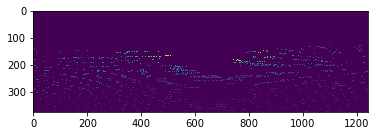

In [89]:
plt.imshow(depth)
plt.show()

In [137]:
def evaluate_eigen_split(predicted_disp_path, gt_path, crop, min_depth, max_depth):
    """ Evaluates the predicted depth data for the KITI dataset on 697 images of the Eigensplit, by using the Velodyne
    points for Reprojection

    Args:
        -predicted_disp_path (string): path for the predicted disparities
        -gt_path (string: path for the ground truth
        -crop (string): either 'eigen' or 'garg' depending on which crop to use 
        -min_depth (int): minimal depth that will be used 
        -max_depth (int): maximal depth that will be used 

    Returns:
        -abs_rel
        -sq_rel
        -rmse
        -rmse_log
        -a1
        -a2
        -a3
    """
    
    pred_disparities = np.load(predicted_disp_path)
    
    num_samples = 697
    test_files = read_text_lines(self.gt_path + 'eigen_test_files.txt')
    gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(test_files, self.gt_path)

    num_test = len(im_files)
    gt_depths = []
    pred_depths = []

    for t_id in range(num_samples):
        #generate the depth map from the ground truth velodyne laser scans 
        camera_id = cams[t_id]  # 2 is left, 3 is right
        depth = generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], camera_id, False, True)
        gt_depths.append(depth.astype(np.float32))
        
        #scale the predicted disparity map to the size of the ground truth and match the scale of the disparities
        disp_pred = cv2.resize(pred_disparities[t_id], (im_sizes[t_id][1], im_sizes[t_id][0]), interpolation=cv2.INTER_LINEAR)
        disp_pred = disp_pred * disp_pred.shape[1]

        # convert from disparity to depth, by the depth formula (baseline*focal_length / disp_pred)
        focal_length, baseline = get_focal_length_baseline(gt_calib[t_id], camera_id)
        depth_pred = (baseline * focal_length) / disp_pred
        depth_pred[np.isinf(depth_pred)] = 0

        pred_depths.append(depth_pred)
    
    #initialize arrays for all the errors 
    rms     = np.zeros(num_samples, np.float32)
    log_rms = np.zeros(num_samples, np.float32)
    abs_rel = np.zeros(num_samples, np.float32)
    sq_rel  = np.zeros(num_samples, np.float32)
    d1_all  = np.zeros(num_samples, np.float32)
    a1      = np.zeros(num_samples, np.float32)
    a2      = np.zeros(num_samples, np.float32)
    a3      = np.zeros(num_samples, np.float32)
    
    for i in range(num_samples):
        gt_depth = gt_depths[i]
        pred_depth = pred_depths[i]
        
        pred_depth[pred_depth < min_depth] = min_depth
        pred_depth[pred_depth > max_depth] = max_depth
        
        #only use those pixels that are within the specified depth range
        mask = np.logical_and(gt_depth > min_depth, gt_depth < max_depth)
        
        #use different crops 
        if self.crop == 'garg' or self.crop == 'eigen':
            gt_height, gt_width = gt_depth.shape

            # crop used by Garg ECCV16
            # if used on gt_size 370x1224 produces a crop of [-218, -3, 44, 1180]
            if self.crop == 'garg':
                self.crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                                     0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)
                # crop we found by trial and error to reproduce Eigen NIPS14 results
            elif self.crop == 'eigen':
                self.crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,   
                                     0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)
            
            #apply a mask to look only at certain pixels that lie within the crop and are valid pixels to evaluate
            crop_mask = np.zeros(mask.shape)
            crop_mask[self.crop[0]:self.crop[1],self.crop[2]:self.crop[3]] = 1
            mask = np.logical_and(mask, crop_mask)
            
        abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])
        
    return abs_rel, sq_rel, rms, log_rms, a1, a2, a3 

In [150]:
import numpy as np
import os
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
#from eval.eval_utils import compute_errors

from PIL import Image

class EvaluateEigen():
    """
    Class that evaluates the KITTI data set on the Eigensplit

    How to use this class:
    Create an object of the type EvaluateEigen() and then use the evaluate method to evaluate



    """

    def __init__(self,predicted_disp_path,gt_path,test_file_path,crop = 'None', min_depth=0,max_depth=80):
        """
        Args:
            -predicted_disp_path (string): path for the predicted disparities
            -gt_path (string: path for the ground truth
            -test_file_path (string): path where the 'eigen_test_files.txt' can be found
            -crop (string): either 'eigen' or 'garg' depending on which crop to use
            -min_depth (int): minimal depth that will be used
            -max_depth (int): maximal depth that will be used
        """
        super(EvaluateEigen, self).__init__()
        self.predicted_disp_path = predicted_disp_path
        self.gt_path = gt_path
        self.test_file_path = test_file_path
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.crop = crop

    def evaluate(self):
        """ Evaluates the predicted depth data for the KITI dataset on 697 images of the Eigensplit, by using the Velodyne
        points for Reprojection


        Returns:
            -abs_rel
            -sq_rel
            -rmse
            -rmse_log
            -a1
            -a2
            -a3
        """

        pred_disparities = np.load(self.predicted_disp_path)

        num_samples = 3
        test_files = self.__read_text_lines(self.test_file_path + 'eigen_test_files.txt')
        gt_files, gt_calib, im_sizes, im_files, cams = self.__read_file_data(test_files, self.gt_path)

        num_test = len(im_files)
        gt_depths = []
        pred_depths = []

        for t_id in range(num_samples):
            #generate the depth map from the ground truth velodyne laser scans
            camera_id = cams[t_id]  # 2 is left, 3 is right
            depth = self.__generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], camera_id, False, True)
            gt_depths.append(depth.astype(np.float32))

            #scale the predicted disparity map to the size of the ground truth and match the scale of the disparities
            disp_pred = cv2.resize(pred_disparities[t_id], (im_sizes[t_id][1], im_sizes[t_id][0]), interpolation=cv2.INTER_LINEAR)
            disp_pred = disp_pred * disp_pred.shape[1]

            # convert from disparity to depth, by the depth formula (baseline*focal_length / disp_pred)
            focal_length, baseline = self.__get_focal_length_baseline(gt_calib[t_id], camera_id)
            depth_pred = (baseline * focal_length) / disp_pred
            depth_pred[np.isinf(depth_pred)] = 0

            pred_depths.append(depth_pred)

        #initialize arrays for all the errors
        rms     = np.zeros(num_samples, np.float32)
        log_rms = np.zeros(num_samples, np.float32)
        abs_rel = np.zeros(num_samples, np.float32)
        sq_rel  = np.zeros(num_samples, np.float32)
        d1_all  = np.zeros(num_samples, np.float32)
        a1      = np.zeros(num_samples, np.float32)
        a2      = np.zeros(num_samples, np.float32)
        a3      = np.zeros(num_samples, np.float32)

        for i in range(num_samples):
            gt_depth = gt_depths[i]
            pred_depth = pred_depths[i]

            pred_depth[pred_depth < self.min_depth] = self.min_depth
            pred_depth[pred_depth > self.max_depth] = self.max_depth

            #only use those pixels that are within the specified depth range
            mask = np.logical_and(gt_depth > self.min_depth, gt_depth < self.max_depth)

            #use different crops
            if self.crop == 'garg' or self.crop == 'eigen':
                gt_height, gt_width = gt_depth.shape

                # crop used by Garg ECCV16
                # if used on gt_size 370x1224 produces a crop of [-218, -3, 44, 1180]
                if self.crop == 'garg':
                    self.crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,
                                         0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)
                    # crop we found by trial and error to reproduce Eigen NIPS14 results
                elif self.crop == 'eigen':
                    self.crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,
                                         0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

                #apply a mask to look only at certain pixels that lie within the crop and are valid pixels to evaluate
                crop_mask = np.zeros(mask.shape)
                crop_mask[self.crop[0]:self.crop[1],self.crop[2]:self.crop[3]] = 1
                mask = np.logical_and(mask, crop_mask)

            abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])

        return abs_rel, sq_rel, rms, log_rms, a1, a2, a3

    def __read_file_data(self, files, data_root):
        """ Reads in the files for evaluation of ground truth data

            Args:
                files (list string): a list of filenames (two files per line left/right)
                data_root (string): root folder

            Returns:
                -gt_files (list string): filenames for the velodyne points (gt from laser range scanner)
                -gt_calib (list string): path for respective camera calibration files of the particular sequence
                -im_sizes (list tuples): sizes of each gt file for later resizing
                -im_files (list string): list of filenames for left images
                -cams (list int): list of camera that image was taken from (2 is left and 3 is right)
            """

        gt_files = []
        gt_calib = []
        im_sizes = []
        im_files = []
        cams = []
        num_probs = 0

        for filename in files:
            filename = filename.split()[0]
            splits = filename.split('/')
            date = splits[0]
            im_id = splits[4][:10]

            im = filename
            vel = '{}/{}/velodyne_points/data/{}.bin'.format(splits[0], splits[1], im_id)

            if os.path.isfile(data_root + im):
                gt_files.append(data_root + vel)
                gt_calib.append(data_root + date + '/')
                im_sizes.append(cv2.imread(data_root + im).shape[:2])
                im_files.append(data_root + im)
                cams.append(2)
            else:
                num_probs += 1
                print('{} missing'.format(data_root + im))

        print(num_probs, 'files missing')

        return gt_files, gt_calib, im_sizes, im_files, cams

    def __load_velodyne_points(self, file_name):
        """ Reads in the ground truth depth file
            # adapted from https://github.com/hunse/kitti

            Args:
                file_name(string): path to velodyne bin file to be loaded

            Returns:
                -points (2D): points
        """

        points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
        points[:, 3] = 1.0  # homogeneous
        return points

    def __lin_interp(self, shape, xyd):
        """ Linearly interpolates the depth data to fill zero holes # adapted from https://github.com/hunse/kitti

            Args:
                -shape(tuple): size of the image
                -xyd (np array):

            Returns:
                -points (2D): points
        """

        m, n = shape
        ij, d = xyd[:, 1::-1], xyd[:, 2]
        f = LinearNDInterpolator(ij, d, fill_value=0)
        J, I = np.meshgrid(np.arange(n), np.arange(m))
        IJ = np.vstack([I.flatten(), J.flatten()]).T
        disparity = f(IJ).reshape(shape)
        return disparity

    def __read_calib_file(self, path):
        """ Reads in in the calibration files for the camera and puts them into a dictionary
        check here for contents of the calibration file:  https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT
        adapted from https://github.com/hunse/kitti

        Args:
            -path(string): path to the calibration file

        Returns:
            -data (dict): dictionary that is storing the different calibration arrays
        """

        float_chars = set("0123456789.e+- ")
        data = {}
        with open(path, 'r') as f:
            for line in f.readlines():
                key, value = line.split(':', 1)
                value = value.strip()
                data[key] = value
                if float_chars.issuperset(value):
                    # try to cast to float array
                    try:
                        # data[key] = np.array(map(float, value.split(' ')))
                        data[key] = np.array([float(value) for value in value.split(' ')])
                    except ValueError:
                        # casting error: data[key] already eq. value, so pass
                        pass

        return data

    def __get_focal_length_baseline(self,calib_dir, cam):
        """ Reads in the ground truth depth file
            # adapted from https://github.com/hunse/kitti

            Args:
                -calib_dir(string): path to camera calibration folder
                -cam (int) camera that was used (either camera 1 or camera 2)

            Returns:
                -focal length (float): focal length of the camera used
                -baseline (float): length of the baseline of the camera used
            """

        cam2cam = self.__read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
        P2_rect = cam2cam['P_rect_02'].reshape(3, 4)
        P3_rect = cam2cam['P_rect_03'].reshape(3, 4)

        # cam 2 is left of camera 0  -6cm
        # cam 3 is to the right  +54cm
        b2 = P2_rect[0, 3] / -P2_rect[0, 0]
        b3 = P3_rect[0, 3] / -P3_rect[0, 0]
        baseline = b3 - b2

        if cam == 2:
            focal_length = P2_rect[0, 0]
        elif cam == 3:
            focal_length = P3_rect[0, 0]

        return focal_length, baseline

    def __sub2ind(self,matrixSize, rowSub, colSub):
        """ Converts an index into our number so can be acessed in an array

        Args:
            -matrixSize (tuple): size of the matrix
            -rowSub (int): row index
            -colSub (int): column index

        Returns:
            -index (int): particular index in a flat array
        """

        m, n = matrixSize
        return rowSub * (n - 1) + colSub - 1

    def __generate_depth_map(self,calib_dir, velo_file_name, im_shape, cam=2, interp=False, vel_depth=False):
        """ Generates a depth map from the velodyne files using the calibration files

        Args:
            -calib_dir (string): Directory of the calibration files
            -velo_file_name (string): Filename of the velodyne.bin file
            -im_shape (tuple): size of the target image, to which the velodyne points are projected
            -cam (int): indicates which cam the image was taken from to load the respective calibration file

        Returns:
            -index (int): particular index in a flat array
        """
        # load calibration files
        cam2cam = self.__read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
        velo2cam = self.__read_calib_file(calib_dir + 'calib_velo_to_cam.txt')
        velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
        velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

        # compute projection matrix velodyne->image plane
        R_cam2rect = np.eye(4)
        R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
        P_rect = cam2cam['P_rect_0' + str(cam)].reshape(3, 4)
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

        # load velodyne points and remove all behind image plane (approximation)
        # each row of the velodyne data is forward, left, up, reflectance
        velo = self.__load_velodyne_points(velo_file_name)
        velo = velo[velo[:, 0] >= 0, :]

        # project the points to the camera
        velo_pts_im = np.dot(P_velo2im, velo.T).T
        velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

        if vel_depth:
            velo_pts_im[:, 2] = velo[:, 0]

        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        # project to image
        depth = np.zeros(im_shape)
        depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

        # find the duplicate points and choose the closest depth
        inds = self.__sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
        dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
        for dd in dupe_inds:
            pts = np.where(inds == dd)[0]
            x_loc = int(velo_pts_im[pts[0], 0])
            y_loc = int(velo_pts_im[pts[0], 1])
            depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
        depth[depth < 0] = 0

        if interp:
            # interpolate the depth map to fill in holes
            depth_interp = self.__lin_interp(im_shape, velo_pts_im)
            return depth, depth_interp
        else:
            return depth
        
        
    def __read_text_lines(self,file_path):
        """ Reads in the ground truth depth file
        # adapted from https://github.com/hunse/kitti

        Args:
            -file_path (string): path to file 
        Returns:
            -lines(list): filenames for the data
        """
        f = open(file_path, 'r')
        lines = f.readlines()
        f.close()
        lines = [l.rstrip() for l in lines]
        return lines

In [151]:
EvaluateEigen('pred_disp.npy', test_file_path='', gt_path = '../../data/kitti/').evaluate()

0 files missing


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in true_divide


(array([ 0.99769968,  0.99768972,  0.99772263], dtype=float32),
 array([ 18.66298866,  18.38948822,  18.45478439], dtype=float32),
 array([ 22.54434013,  22.20382309,  22.21712494], dtype=float32),
 array([ 6.76411104,  6.73685884,  6.74664402], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32))